In [1]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import os

Parámetros del sistema

In [2]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 4 # Frecuencia natural x<0
f_0 = 4 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
amort = 0.125 # constante de amortiguamiento
N = 200 # Numero de fonones
X_0 = 10 # Condición inicial

In [3]:
dw = 0.001 # paso en la frecuencia externa
wc =  np.array([i*dw for i in range(int(1.1/dw),int(1.6/dw)+1)]) # Frecuencia fuerza externa
np.size(wc)

501

In [4]:
w =  wc[[i*7 for i in range(72)]] # Frecuencia fuerza externa
n = np.size(w)
print(w)

[1.1   1.107 1.114 1.121 1.128 1.135 1.142 1.149 1.156 1.163 1.17  1.177
 1.184 1.191 1.198 1.205 1.212 1.219 1.226 1.233 1.24  1.247 1.254 1.261
 1.268 1.275 1.282 1.289 1.296 1.303 1.31  1.317 1.324 1.331 1.338 1.345
 1.352 1.359 1.366 1.373 1.38  1.387 1.394 1.401 1.408 1.415 1.422 1.429
 1.436 1.443 1.45  1.457 1.464 1.471 1.478 1.485 1.492 1.499 1.506 1.513
 1.52  1.527 1.534 1.541 1.548 1.555 1.562 1.569 1.576 1.583 1.59  1.597]


Frecuencia natural del oscilador

In [5]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [6]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [7]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    if n > 155:
        ayuda = 10**n
    else:
        ayuda = 1
    phi = (m*w_0/np.pi)**(0.25)*math.sqrt(ayuda/(2**n*np.math.factorial(n)))*(1/math.sqrt(ayuda))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [8]:
x = np.linspace(-25,25,2500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

  0%|          | 0/200 [00:00<?, ?it/s]

c:\Users\carme\anaconda3\envs\myenv\Lib\site-packages\scipy\special\_orthogonal.py:1304: RuntimeWarning: overflow encountered in multiply
  hn = 2**n * _gam(n + 1) * sqrt(pi)
100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


c:\Users\carme\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\carme\anaconda3\envs\myenv\Lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


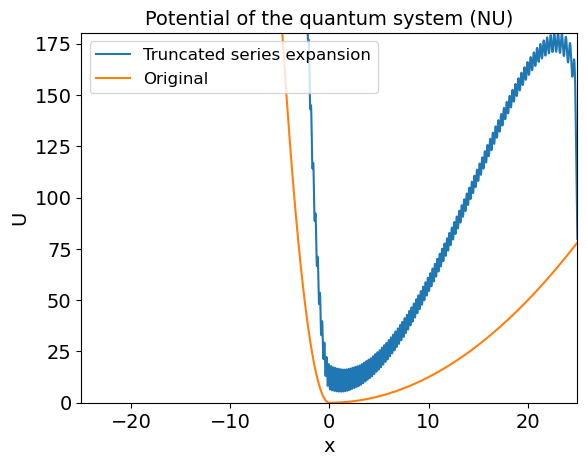

In [9]:
fig1 = plt.figure()
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system (NU)',fontsize = 14)
plt.xlabel('x',fontsize = 14)
plt.ylabel('U',fontsize = 14)
plt.legend(fontsize = 12)
plt.show()

In [10]:
newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [11]:
fig1.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Quantum_potential (N = '+str(N)+' phonons).png')

Simulación de la dinámica cuántica

In [6]:
dt = 0.01 # Paso de tiempo
t0 = 0
tf = 500 # Tiempo de medida
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [13]:
lines = ['dt = '+str(dt),'tf = '+str(tf),'w_0 = '+str(w_0),'W_0 = '+str(W_0),'f_0 = '+str(f_0),'amort = '+str(amort),'N = '+str(N),'X_0 = '+str(X_0),'w = '+str(w)]
with open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/param.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [14]:
def check_state(psi):
    check = np.sum(psi[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [34]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5)*math.sqrt(w_0*m))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m)
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

In [16]:
def H1coeff(t,args):
    return -f_0*m*np.cos(args['w']*t)

In [17]:
result = []
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
x_exp = position(N)/math.sqrt(w_0*m)
p_exp = momentum(N)*math.sqrt(w_0*m)
x2_exp = position(N)**2/(w_0*m)
p2_exp = momentum(N)**2*(w_0*m)
coll = math.sqrt(2*amort*m)*destroy(N)
options = Options(store_states=True,nsteps=1000000,ntraj=1)
for i in tqdm(range(n)):
    args = {'w': w[i]}
    H = [H0,[H1,H1coeff]]
    result.append(mcsolve(H, psi0, tvec, [coll], [x_exp,p_exp,x2_exp,p2_exp],options=options,args=args))

  0%|          | 0/72 [00:00<?, ?it/s]

Total run time: 491.93s


  1%|▏         | 1/72 [08:12<9:42:39, 492.39s/it]

Total run time: 489.86s


  3%|▎         | 2/72 [16:22<9:33:05, 491.22s/it]

Total run time: 487.82s


  4%|▍         | 3/72 [24:31<9:23:22, 489.90s/it]

Total run time: 496.63s


  6%|▌         | 4/72 [32:48<9:18:27, 492.76s/it]

Total run time: 488.80s


  7%|▋         | 5/72 [40:57<9:08:52, 491.52s/it]

Total run time: 483.43s


  8%|▊         | 6/72 [49:01<8:57:48, 488.92s/it]

Total run time: 476.80s


 10%|▉         | 7/72 [56:58<8:45:33, 485.13s/it]

Total run time: 477.53s


 11%|█         | 8/72 [1:04:56<8:35:01, 482.84s/it]

Total run time: 469.67s


 12%|█▎        | 9/72 [1:12:46<8:22:50, 478.90s/it]

Total run time: 470.87s


 14%|█▍        | 10/72 [1:20:38<8:12:26, 476.56s/it]

Total run time: 465.86s


 15%|█▌        | 11/72 [1:28:24<8:01:22, 473.48s/it]

Total run time: 464.33s


 17%|█▋        | 12/72 [1:36:09<7:50:48, 470.82s/it]

Total run time: 461.60s


 18%|█▊        | 13/72 [1:43:51<7:40:20, 468.15s/it]

Total run time: 460.94s


 19%|█▉        | 14/72 [1:51:33<7:30:38, 466.18s/it]

Total run time: 457.03s


 21%|██        | 15/72 [1:59:10<7:20:21, 463.54s/it]

Total run time: 459.43s


 22%|██▏       | 16/72 [2:06:50<7:11:35, 462.42s/it]

Total run time: 459.13s


 24%|██▎       | 17/72 [2:14:29<7:03:05, 461.56s/it]

Total run time: 464.44s


 25%|██▌       | 18/72 [2:22:15<6:56:22, 462.64s/it]

Total run time: 457.07s


 26%|██▋       | 19/72 [2:29:52<6:47:17, 461.09s/it]

Total run time: 454.08s


 28%|██▊       | 20/72 [2:37:27<6:37:53, 459.11s/it]

Total run time: 450.20s


 29%|██▉       | 21/72 [2:44:57<6:28:04, 456.56s/it]

Total run time: 453.69s


 31%|███       | 22/72 [2:52:32<6:19:56, 455.94s/it]

Total run time: 445.09s


 32%|███▏      | 23/72 [2:59:57<6:09:48, 452.82s/it]

Total run time: 451.53s


 33%|███▎      | 24/72 [3:07:29<6:02:03, 452.57s/it]

Total run time: 447.13s


 35%|███▍      | 25/72 [3:14:57<5:53:20, 451.07s/it]

Total run time: 447.36s


 36%|███▌      | 26/72 [3:22:25<5:45:05, 450.11s/it]

Total run time: 446.56s


 38%|███▊      | 27/72 [3:29:52<5:36:52, 449.18s/it]

Total run time: 445.39s


 39%|███▉      | 28/72 [3:37:18<5:28:46, 448.32s/it]

Total run time: 445.13s


 40%|████      | 29/72 [3:44:44<5:20:42, 447.49s/it]

Total run time: 440.20s


 42%|████▏     | 30/72 [3:52:04<5:11:48, 445.44s/it]

Total run time: 441.81s


 43%|████▎     | 31/72 [3:59:26<5:03:44, 444.49s/it]

Total run time: 440.89s


 44%|████▍     | 32/72 [4:06:48<4:55:41, 443.55s/it]

Total run time: 443.87s


 46%|████▌     | 33/72 [4:14:12<4:48:27, 443.78s/it]

Total run time: 439.51s


 47%|████▋     | 34/72 [4:21:32<4:40:20, 442.64s/it]

Total run time: 445.77s


 49%|████▊     | 35/72 [4:28:59<4:33:44, 443.89s/it]

Total run time: 439.50s


 50%|█████     | 36/72 [4:36:19<4:25:37, 442.71s/it]

Total run time: 436.24s


 51%|█████▏    | 37/72 [4:43:36<4:17:11, 440.90s/it]

Total run time: 434.80s


 53%|█████▎    | 38/72 [4:50:51<4:08:52, 439.20s/it]

Total run time: 437.47s


 54%|█████▍    | 39/72 [4:58:09<4:01:20, 438.82s/it]

Total run time: 432.79s


 56%|█████▌    | 40/72 [5:05:22<3:53:08, 437.14s/it]

Total run time: 436.79s


 57%|█████▋    | 41/72 [5:12:39<3:45:52, 437.18s/it]

Total run time: 439.02s


 58%|█████▊    | 42/72 [5:19:59<3:38:55, 437.86s/it]

Total run time: 438.59s


 60%|█████▉    | 43/72 [5:27:18<3:31:48, 438.22s/it]

Total run time: 445.62s


 61%|██████    | 44/72 [5:34:45<3:25:42, 440.79s/it]

Total run time: 438.38s


 62%|██████▎   | 45/72 [5:42:03<3:18:05, 440.21s/it]

Total run time: 436.67s


 64%|██████▍   | 46/72 [5:49:20<3:10:21, 439.28s/it]

Total run time: 434.01s


 65%|██████▌   | 47/72 [5:56:35<3:02:25, 437.83s/it]

Total run time: 434.50s


 67%|██████▋   | 48/72 [6:03:50<2:54:47, 436.97s/it]

Total run time: 436.39s


 68%|██████▊   | 49/72 [6:11:07<2:47:29, 436.94s/it]

Total run time: 436.70s


 69%|██████▉   | 50/72 [6:18:24<2:40:13, 436.99s/it]

Total run time: 440.76s


 71%|███████   | 51/72 [6:25:45<2:33:23, 438.26s/it]

Total run time: 431.28s


 72%|███████▏  | 52/72 [6:32:57<2:25:26, 436.30s/it]

Total run time: 429.67s


 74%|███████▎  | 53/72 [6:40:07<2:17:34, 434.45s/it]

Total run time: 435.22s


 75%|███████▌  | 54/72 [6:47:23<2:10:26, 434.82s/it]

Total run time: 434.69s


 76%|███████▋  | 55/72 [6:54:39<2:03:18, 435.22s/it]

Total run time: 428.24s


 78%|███████▊  | 56/72 [7:01:48<1:55:32, 433.26s/it]

Total run time: 431.44s


 79%|███████▉  | 57/72 [7:08:59<1:48:13, 432.88s/it]

Total run time: 429.97s


 81%|████████  | 58/72 [7:16:10<1:40:49, 432.14s/it]

Total run time: 427.30s


 82%|████████▏ | 59/72 [7:23:18<1:33:20, 430.82s/it]

Total run time: 431.21s


 83%|████████▎ | 60/72 [7:30:29<1:26:13, 431.08s/it]

Total run time: 431.92s


 85%|████████▍ | 61/72 [7:37:42<1:19:06, 431.46s/it]

Total run time: 434.34s


 86%|████████▌ | 62/72 [7:44:56<1:12:04, 432.46s/it]

Total run time: 433.32s


 88%|████████▊ | 63/72 [7:52:10<1:04:55, 432.86s/it]

Total run time: 431.75s


 89%|████████▉ | 64/72 [7:59:22<57:41, 432.66s/it]  

Total run time: 435.70s


 90%|█████████ | 65/72 [8:06:39<50:36, 433.72s/it]

Total run time: 430.97s


 92%|█████████▏| 66/72 [8:13:50<43:18, 433.03s/it]

Total run time: 429.06s


 93%|█████████▎| 67/72 [8:21:00<35:59, 431.98s/it]

Total run time: 435.08s


 94%|█████████▍| 68/72 [8:28:15<28:52, 433.05s/it]

Total run time: 431.48s


 96%|█████████▌| 69/72 [8:35:28<21:39, 433.08s/it]

Total run time: 426.91s


 97%|█████████▋| 70/72 [8:42:36<14:22, 431.37s/it]

Total run time: 431.09s


 99%|█████████▊| 71/72 [8:49:47<07:11, 431.42s/it]

Total run time: 434.46s


100%|██████████| 72/72 [8:57:02<00:00, 447.54s/it]


Time series information

In [18]:
O = []
coh = []
indW = np.array([np.searchsorted(tvec,i) for i in range(tf)]) # Calculamos los índices
tW = tvec[indW]

for j in range(n):
    aux = []
    aux2 = []
    for i in tqdm(range(np.size(tW))): 
        psi = result[j].states[0][int(tW[i]/dt)]
        #check_state(psi)
        alpha = expect(destroy(N),psi)
        
        psi_t = coherent(N,alpha)
        aux.append(abs(psi.overlap(psi0)))
        aux2.append(abs(psi_t.overlap(psi)))
    O.append(aux)
    coh.append(aux2)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:21<00:00, 22.75it/s]


In [19]:
S = np.zeros([n,np.size(tW)])
P = np.zeros([n,np.size(tW)])

for j in range(n):
    for i in tqdm(range(np.size(tW))):
        Q = ket2dm(result[j].states[0][int(tW[i]/dt)])
        S[j,i] = entropy_vn(Q)
        P[j,i] = abs(np.trace(Q*Q))

100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


In [20]:
exp_x = []
exp_p = []
desv_x = []
desv_p = []

xp_Q = []
pp_Q = []

for i in range(n):
    exp_x.append(result[i].expect[0])
    exp_p.append(result[i].expect[1])
    desv_x.append(np.sqrt(result[i].expect[2]-result[i].expect[0]*result[i].expect[0]))
    desv_p.append(np.sqrt(result[i].expect[3]-result[i].expect[1]*result[i].expect[1]))

    T = 2*np.pi/w[i] # Periodo fuerza externa
    Np_Q = int(tf/T) # Número de puntos del diagrama de Poincaré
    ind_Q = np.array([np.searchsorted(tvec,T*(j+1)) for j in range(Np_Q-1)]) # Calculamos los índices del diagrama de Poincaré
    xp_Q.append(exp_x[i][ind_Q]) # Asignamos índices encontrados en tiempos con posiciones y velocidades (/max(x[ind]))
    pp_Q.append(exp_p[i][ind_Q])

Quantum bifurcation diagram and Poincare section

In [62]:
wig_xvec = np.linspace(-1,7,120)
wig_pvec = np.linspace(-15,25,120)
qbif = np.zeros([np.size(w),np.size(wig_pvec)])
Qpoin = []
qfunc_calculator = QFunc(wig_xvec, wig_pvec)
num = 30

for k in tqdm(range(n)):

    T = 2*math.pi/w[k] # Periodo fuerza externa
    Np = int(tf/T) # Número de puntos que usamos en el promedio
    ind = np.array([np.searchsorted(tvec,T*(i+1)) for i in range(Np-1)]) # Calculamos los índices
    aux = 0
    aux2 = 0

    dop = np.zeros([np.size(ind),np.size(wig_xvec)])
    Wigs = np.zeros([np.size(ind),np.size(wig_xvec),np.size(wig_pvec)])

    for j in tqdm(range(np.size(ind))):
        Wigner = qfunc_calculator(result[k].states[0][ind[j]]) #wigner(result[k].states[0][ind[j]], wig_xvec, wig_pvec) # USO HUSIMI CUIDADO NOMBRES MAL
        dop[j] = [scipy.integrate.simpson(Wigner[i,:],wig_xvec) for i in range(np.size(wig_xvec))]
        Wigs[j] = Wigner

    for i in range(1,int(np.size(ind)-num)):
            aux = aux + dop[-i]
            aux2 = aux2 + Wigs[-i]
    qbif[k] = aux*math.sqrt(w_0*m)/(int(np.size(ind)-num))
    qpoin = aux2/int(np.size(ind)-num)
    Qpoin.append(qpoin)

100%|██████████| 72/72 [01:44<00:00,  1.45s/it]


Quantum Poincaré section T

In [217]:
wig_xvec = np.linspace(-1,7,120)
wig_pvec = np.linspace(-15,25,120)
wT = w[44]
TT = 2*math.pi/wT # Periodo fuerza externa
NpT = int(tf/TT) # Número de puntos que usamos en el promedio
qbifT = np.zeros([int(np.round(TT*10)),np.size(wig_pvec)])
QpoinT = []
qfunc_calculator = QFunc(wig_xvec, wig_pvec)
num = 30

for k in tqdm(range(int(np.round(TT*10)))):

    indT = np.array([np.searchsorted(tvec,TT*(i+1)+k*0.1) for i in range(NpT-1)]) # Calculamos los índices
    aux = 0
    aux2 = 0

    dop = np.zeros([np.size(indT),np.size(wig_xvec)])
    Wigs = np.zeros([np.size(indT),np.size(wig_xvec),np.size(wig_pvec)])

    for j in tqdm(range(np.size(indT))):
        Wigner = qfunc_calculator(result[44].states[0][indT[j]]) #wigner(result[k].states[0][ind[j]], wig_xvec, wig_pvec) # USO HUSIMI CUIDADO NOMBRES MAL
        dop[j] = [scipy.integrate.simpson(Wigner[i,:],wig_xvec) for i in range(np.size(wig_xvec))]
        Wigs[j] = Wigner

    for i in range(1,int(np.size(indT)-num)):
            aux = aux + dop[-i]
            aux2 = aux2 + Wigs[-i]
    qbifT[k] = aux*math.sqrt(w_0*m)/(int(np.size(indT)-num))
    qpoinT = aux2/int(np.size(indT)-num)
    QpoinT.append(qpoinT)

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Save data and figures

In [64]:
newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\qbif' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\qpoin' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\overlap' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\coh' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\esp' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\purity' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\entropy' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Qpoin_esp' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Qpoin_T' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

Guardamos los datos

In [65]:
for i in tqdm(range(np.size(w))):
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\qbif/qbif ω = '+str(format(w[i],'.4f'))+'.txt',qbif[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\qpoin/qpoin ω = '+str(format(w[i],'.4f'))+'.txt',Qpoin[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\coh/coh ω = '+str(format(w[i],'.4f'))+'.txt',coh[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\overlap/overlap ω = '+str(format(w[i],'.4f'))+'.txt',O[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\purity/purity ω = '+str(format(w[i],'.4f'))+'.txt',P[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\entropy/entropy ω = '+str(format(w[i],'.4f'))+'.txt',S[i])
    esp = np.column_stack([exp_x[i],exp_p[i],desv_x[i],desv_p[i]])
    poinesp = np.column_stack([xp_Q[i],pp_Q[i]])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\esp/esp ω = '+str(format(w[i],'.4f'))+'.txt',esp)
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Qpoin_esp/Qpoin_esp ω = '+str(format(w[i],'.4f'))+'.txt',poinesp)

for i in tqdm(range(int(np.round(TT*10)))):
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Qpoin_T/qpoin ω = '+str(format(w[i],'.4f'))+'.txt',QpoinT[i])

100%|██████████| 72/72 [06:29<00:00,  5.41s/it]


Cargamos los datos

In [10]:
x = np.linspace(-25,25,2500)
wig_xvec = np.linspace(-1,7,120)
wig_pvec = np.linspace(-15,25,120)
indW = np.array([np.searchsorted(tvec,i) for i in range(tf)]) # Calculamos los índices
tW = tvec[indW]
#T = 2*np.pi/w[i]
#Np_Q = int(tf/T)
qbif = np.zeros([n,wig_xvec.size])
qpoin = np.zeros([n,wig_xvec.size,wig_pvec.size])
O = np.zeros([n,tW.size])
coh = np.zeros([n,tW.size])
neg = np.zeros([n,tW.size])
x_exp = np.zeros([n,tvec.size])
p_exp = np.zeros([n,tvec.size])
desv_x = np.zeros([n,tvec.size])
desv_p = np.zeros([n,tvec.size])
P = np.zeros([n,tW.size])
S = np.zeros([n,tW.size])
xp_Q = np.zeros([n,50])
pp_Q = np.zeros([n,50])


for i in range(n):
    a = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\qbif/qbif ω = '+str(format(w[i],'.4f'))+'.txt','r')
    d = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\qpoin/qpoin ω = '+str(format(w[i],'.4f'))+'.txt','r')
    f = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\coh/coh ω = '+str(format(w[i],'.4f'))+'.txt','r')
    g = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\overlap/overlap ω = '+str(format(w[i],'.4f'))+'.txt','r')
    h = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\esp/esp ω = '+str(format(w[i],'.4f'))+'.txt','r')
    l = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\purity/purity ω = '+str(format(w[i],'.4f'))+'.txt','r')
    o = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\entropy/entropy ω = '+str(format(w[i],'.4f'))+'.txt','r')
    q = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Qpoin_esp/Qpoin_esp ω = '+str(format(w[i],'.4f'))+'.txt','r')
    
    Qbif = a.readlines()
    Qsec = d.readlines()
    Coh = f.readlines()
    Overlap = g.readlines()
    Esp = h.readlines()
    Purity = l.readlines()
    Entropy = o.readlines()
    Poinesp = q.readlines()

    for j in range(len(Qbif)):
        Qbif[j] = float((Qbif[j].split())[0])
    qbif[i] = (Qbif)
    
    for k in range(len(Qsec)):
        for j in range(len(Qsec)):
            qpoin[i][k][j] = float((Qsec[k].split())[j])

    for j in range(len(Coh)):
        Coh[j] = float((Coh[j].split())[0])
    coh[i] = (Coh)
   
    for j in range(len(Overlap)):
        Overlap[j] = float((Overlap[j].split())[0])
    O[i] = (Overlap)

    for j in range(len(Purity)):
        Purity[j] = float((Purity[j].split())[0])
    P[i] = (Purity)

    for j in range(len(Entropy)):
        Entropy[j] = float((Entropy[j].split())[0])
    S[i] = (Entropy)

    for j in range(len(Esp)):
        x_exp[i][j] = float((Esp[j].split())[0])
        p_exp[i][j] = float((Esp[j].split())[1])
        desv_x[i][j] = float((Esp[j].split())[2])
        desv_p[i][j] = float((Esp[j].split())[3])

    for j in range(50):
        xp_Q[i][j] = float((Poinesp[j].split())[0])
        pp_Q[i][j] = float((Poinesp[j].split())[1])

In [11]:
wT = w[44]
TT = 2*math.pi/wT # Periodo fuerza externa
NpT = int(tf/TT) # Número de puntos que usamos en el promedio
qpoinT = np.zeros([int(np.round(TT*10)),wig_xvec.size,wig_pvec.size])

for i in range(int(np.round(TT*10))):
    r = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Qpoin_T/qpoin ω = '+str(format(w[i],'.4f'))+'.txt','r')
    
    QsecT = r.readlines()

    for k in range(len(QsecT)):
        for j in range(len(QsecT)):
            qpoinT[i][k][j] = float((QsecT[k].split())[j])

In [12]:
xp = []
vp = []

rep_w = np.searchsorted(wc, w)
for i in range(np.size(wc)):
    b = open(r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+r')\Caos clásico (variación w)\xp/xp ω = '+str(format(wc[i],'.3f'))+'.txt','r')
    c = open(r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+r')\Caos clásico (variación w)\vp/vp ω = '+str(format(wc[i],'.3f'))+'.txt','r')
    XP = b.readlines()
    VP = c.readlines()
    for j in range(len(XP)):
        XP[j] = float((XP[j].split())[0])
        VP[j] = float((VP[j].split())[0])
    xp.append(XP)
    vp.append(VP)

b.close()
c.close()

In [13]:
e = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Caos clásico (variación w)/explyap.txt','r')

explyap = e.readlines()
lyap = np.zeros(np.size(wc))
disp = np.zeros(np.size(wc))

for i in range(np.size(wc)):
    explyap[i] = explyap[i].split()
    lyap[i] = explyap[i][0]
    disp[i] = explyap[i][1]

e.close()

In [14]:
def EDO(t,y,w): # Ecuaciones modificadas, las del oscilador amortiguado clásico serían [v-amort*x,-W(x)**2*x-amort*v+f_0*np.cos(w*t)]
    x,v = y
    return [v,-W(x)**2*x-2*amort*v+f_0*np.cos(w*t)]

In [15]:
pos = []
mom = []

for i in tqdm(range(np.size(w))):

    sol = scipy.integrate.solve_ivp(EDO, [0,tf], [X_0,0], method = 'Radau',t_eval = tvec,args = [w[i]])
    x,v = sol.y
    pos.append(x)
    mom.append(v*m)

100%|██████████| 72/72 [00:57<00:00,  1.25it/s]


Guardamos figuras

In [16]:
est = 300 # tiempo al cual los términos transitorios han desaparecido
num = 30

fou = []

nO = np.size(np.abs(O[0][int(est/(tW[1]-tW[0])):]))
freq = np.fft.fftfreq(nO, tW[1]-tW[0])[:nO//2]

for i in range(n):
    fou.append(scipy.fft.fft(O[i][int(est/(tW[1]-tW[0])):]))

for i in range(n):

    newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    fig2,ax2 = plt.subplots()
    ax2.plot(tW,O[i])
    ax2.set_xlim([0,tf])
    ax2.set_ylim([0,1])
    ax2.set_title('Overlap integral',fontsize = 14)
    ax2.set_xlabel('t',fontsize = 14)
    ax2.set_ylabel('<Ψ(t)|Ψ(0)>',fontsize = 14)
    plt.close()
    fig2.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Overlap (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)

    fig3,ax3 = plt.subplots()
    ax3.plot(tW,coh[i])
    ax3.set_xlim([0,tf])
    ax3.set_ylim([0,1])
    ax3.set_title('Does the state remain coherent as it evolves?',fontsize = 14)
    ax3.set_xlabel('t',fontsize = 14)
    ax3.set_ylabel('Coherence', style = 'italic',fontsize = 14)
    plt.close()
    fig3.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Coherence (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)

    fig12,ax12 = plt.subplots()
    ax12.plot(tW,P[i])
    ax12.set_xlim([0,tf])
    ax12.set_ylim([0,1])
    ax12.set_title('Purity',fontsize = 14)
    ax12.set_xlabel('t',fontsize = 14)
    ax12.set_ylabel(r'tr($\rho$$^2$)', style = 'italic',fontsize = 14)
    plt.close()
    fig12.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Purity (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)

    fig14,ax14 = plt.subplots()
    ax14.plot(tW,S[i])
    ax14.set_xlim([0,tf])
    ax14.set_ylim([min(S[i]),max(S[i])])
    ax14.set_title('Von Neumann entropy',fontsize = 14)
    ax14.set_xlabel('t',fontsize = 14)
    ax14.set_ylabel(r'-tr($\rho$Ln($\rho$))', style = 'italic',fontsize = 14)
    plt.close()
    fig14.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Entropy (ω = '+str(format(w[i],'.4f'))+').png',dpi=250, bbox_inches='tight')

    fig4,ax4 = plt.subplots()
    ax4.plot(freq,(2/nO)*np.abs(fou[i][:nO//2]))
    ax4.set_xlim([np.min(freq),np.max(freq)])
    ax4.set_ylim([0,max((2/nO)*np.abs(fou[i][1:]))])
    ax4.set_title('Frequency spectrum',fontsize = 14)
    ax4.set_xlabel('Frequency',fontsize = 14)
    ax4.set_ylabel('Magnitude',fontsize = 14)
    plt.close()
    fig4.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Frequency spectrum (ω = '+str(format(w[i],'.4f'))+').png',dpi=250, bbox_inches='tight')

    fig5,ax5 = plt.subplots()
    ax5.plot(tvec,desv_x[i], label = 'Δx', alpha = 0.8)
    ax5.plot(tvec,desv_p[i], label = 'Δp', alpha = 0.8)
    ax5.plot(tvec,desv_x[i]*desv_p[i], label = 'Δx·Δp', alpha = 0.4)
    ax5.set_xlim([0,tf])
    ax5.set_title('Time-evolution of the standard deviation',fontsize = 14)
    ax5.set_xlabel('t',fontsize = 14)
    ax5.set_ylabel('Standard deviation',fontsize = 14)
    plt.legend(loc='best',fontsize = 12)
    plt.close()
    fig5.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Standard deviation (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)
 
    plt.rc('xtick', labelsize=22) 
    plt.rc('ytick', labelsize=22)

    fig6 = plt.figure(figsize=(12,12), constrained_layout=True)

    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.0,hspace=0)
    ax6 = plt.subplot(gs[0, :2], )
    ax7 = plt.subplot(gs[0, 2:])
    ax8 = plt.subplot(gs[1, 2:])

    ax7.plot(pos[i][int(est/dt):],mom[i][int(est/dt):],label='Classical values',alpha = 0.7)
    ax7.plot(x_exp[i][int(est/dt):],p_exp[i][int(est/dt):],label='Quantum expected values',color = 'red',alpha = 0.7)
    ax7.set_ylim([-7,7])
    ax7.set_xlim([-2,13])
    #ax7.set_title('Quantum vs. classical phase space',fontsize = 22)
    #ax7.legend(fontsize = 12)
    ax7.tick_params(
        axis='both',
        which='both',
        bottom=True,
        top=False,
        left=True,
        right=False, 
        labelbottom=False,
        labelleft=False)


    ax8.plot(pos[i][int(est/dt):],tvec[int(est/dt):],label='Classical positions',alpha = 0.7)
    ax8.plot(x_exp[i][int(est/dt):],tvec[int(est/dt):],label='Quantum expected values', color = 'red',alpha = 0.7)
    ax8.fill_betweenx(tvec[int(est/dt):],x_exp[i][int(est/dt):]-desv_x[i][int(est/dt):],x_exp[i][int(est/dt):]+desv_x[i][int(est/dt):],alpha = 0.2, color = 'red', label = 'Standard deviation')
    ax8.set_xlim([-2,13])
    ax8.set_ylim([est,tf])
    #ax8.set_title('Quantum vs. classical position',fontsize = 22)
    ax8.set_ylabel('t',fontsize = 22)
    ax8.set_xlabel('x',fontsize = 22)
    ax8.set_yticks([350,450]) 
    ax8.set_yticklabels([350,450], fontsize=22)

    ax6.plot(tvec[int(est/dt):],mom[i][int(est/dt):],label='Classical momentum',alpha = 0.7)
    ax6.plot(tvec[int(est/dt):],p_exp[i][int(est/dt):],label='Quantum expected values', color = 'red',alpha = 0.7)
    ax6.fill_between(tvec[int(est/dt):],p_exp[i][int(est/dt):]-desv_p[i][int(est/dt):],p_exp[i][int(est/dt):]+desv_p[i][int(est/dt):],alpha = 0.2, color = 'red', label = 'Standard deviation')
    ax6.set_ylim([-7,7])
    ax6.set_xlim([est,tf])
    #ax6.set_title('Quantum vs. classical momentum',fontsize = 22)
    ax6.set_xlabel('t',fontsize = 22)
    ax6.set_ylabel('p',fontsize = 22)
    ax6.set_xticks([350,450]) 
    ax6.set_xticklabels([350,450], fontsize=22)

    plt.close()
    fig6.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Classical_vs_quantum (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)
    fig6.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Classical_vs_quantum (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)

    fig15,ax15 = plt.subplots()
    ax15.hist2d(xp_Q[i],pp_Q[i], bins=(50, 50), range = [[np.min(wig_xvec/math.sqrt(w_0*m)),np.max(wig_xvec/math.sqrt(w_0*m))],[np.min(wig_pvec*math.sqrt(w_0*m)),np.max(wig_pvec*math.sqrt(w_0*m))]],cmap=cm.viridis)
    ax15.plot(xp[rep_w[i]][50:]*m,vp[rep_w[i]][50:],'.',color='red',markersize = 10, label = 'Classical values')
    ax15.set_xlim([np.min(wig_xvec/math.sqrt(w_0*m)),np.max(wig_xvec/math.sqrt(w_0*m))])
    ax15.set_ylim([np.min(wig_pvec*math.sqrt(w_0*m)),np.max(wig_pvec*math.sqrt(w_0*m))])
    #ax15.set_title('Poincare section of expected values',fontsize = 14)
    ax15.set_xlabel('x',fontsize = 22)
    ax15.set_ylabel('p',fontsize = 22)
    plt.close()
    fig15.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/ExpPoin (ω = '+str(format(w[i],'.4f'))+').png',dpi=250, bbox_inches='tight')
    fig15.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/ExpPoin (ω = '+str(format(w[i],'.4f'))+').png',dpi=250, bbox_inches='tight')

    plt.rc('xtick', labelsize=22) 
    plt.rc('ytick', labelsize=22)

    fig8,ax8 = plt.subplots()
    wmap = wigner_cmap(qpoin[i])
    nrm = mpl.colors.Normalize(0, qpoin[i].max())
    ax8.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), qpoin[i], 100, cmap=cm.viridis, norm=nrm)
    ax8.set_xlim([np.min(wig_xvec/math.sqrt(w_0*m)),np.max(wig_xvec/math.sqrt(w_0*m))])
    ax8.set_ylim([np.min(wig_pvec*math.sqrt(w_0*m)),np.max(wig_pvec*math.sqrt(w_0*m))])
    ax8.plot(xp[rep_w[i]][50:],vp[rep_w[i]][50:]*m,'.',color='red',markersize = 5,label = 'Classical values')
    ax8.set_xlabel('x',fontsize = 22)
    ax8.set_ylabel('p',fontsize = 22)
    cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.viridis))
    cbar.set_label(label='$<Q(x,p,nT)>$',fontsize = 22)
    plt.close()
    fig8.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qsec (ω = '+str(format(w[i],'.4f'))+').png',dpi=250, bbox_inches='tight')
    fig8.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Qsec (ω = '+str(format(w[i],'.4f'))+').png',dpi=250, bbox_inches='tight')

C:\Users\rodri\AppData\Local\Temp\ipykernel_3520\3162822771.py:131: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig6.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Classical_vs_quantum (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)
C:\Users\rodri\AppData\Local\Temp\ipykernel_3520\3162822771.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig6.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar\Results (ω = '+str(format(w[i],'.4f'))+')/Classical_vs_quantum (ω = '+str(format(w[i],'.4f'))+').png',dpi=250)


In [17]:
num_bin = 100
vp_hist = np.zeros([wc.size,num_bin])

for i in range(wc.size):
    vp_hist[i,:] = np.histogram(vp[i][50:], bins = num_bin, range = [-10,10], density = True)[0]

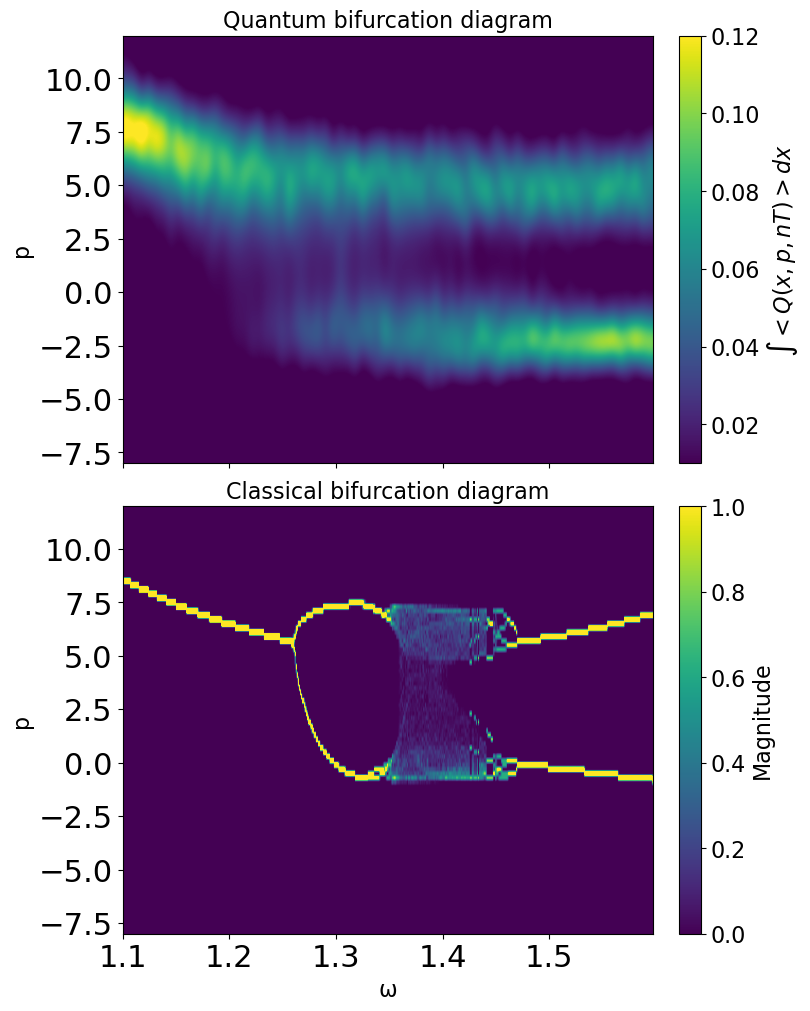

In [18]:
fig9,(ax9,ax16) = plt.subplots(2,1, figsize=(8, 10), sharex = True, constrained_layout=True)

nrm2 = mpl.colors.Normalize(0.01, 0.12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

im = ax9.imshow(np.flip(np.transpose(qbif),axis = 0),cmap='viridis',norm = nrm2, aspect = 'auto', extent = [min(w),max(w),min(wig_pvec*math.sqrt(w_0*m)),max(wig_pvec*math.sqrt(w_0*m))], interpolation = 'bicubic')
cbar2 = plt.colorbar(im, ax = ax9, pad = 0.05)
cbar2.set_label(label='$\int<Q(x,p,nT)>dx$',fontsize = 16)

ax9.set_title('Quantum bifurcation diagram',fontsize = 16)
ax9.set_ylabel('p',fontsize = 16)
ax9.set_ylim(-8,12)
ax9.set_xlim(min(w),max(w))

im2 = ax16.imshow(np.transpose(np.fliplr(vp_hist)),cmap = 'viridis',vmin = 0, vmax = 1, aspect = 'auto', extent = [min(w),max(w),-8,12])
cbar3 = plt.colorbar(im2, ax = ax16, pad = 0.05)
cbar3.set_label(label='Magnitude',fontsize = 16)
ax16.set_ylim(-8,12)
ax16.set_xlabel('ω',fontsize = 16)
ax16.set_ylabel('p',fontsize = 16)
ax16.set_title('Classical bifurcation diagram',fontsize = 16)

fig9.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qbif ('+str(tf)+').png',dpi=250, bbox_inches='tight')
plt.show()

In [19]:
def update_fig(Num,qbif,qpoin,xp,vp):
    ax10.cla()
    ax11.cla()

    nrm = mpl.colors.Normalize(0, 0.06)
    nrm2 = mpl.colors.Normalize(0, 0.12)

    ax10.contourf(wig_pvec*math.sqrt(w_0*m), wig_xvec/math.sqrt(w_0*m), np.transpose(qpoin[Num]), 100, cmap=cm.viridis, norm=nrm)
    im = ax11.imshow(np.flip(qbif,axis = 0),cmap='viridis',norm = nrm2, aspect = 'auto', extent = [min(wig_pvec*math.sqrt(w_0*m)),max(wig_pvec*math.sqrt(w_0*m)),min(w),max(w)], interpolation = 'bicubic')
    
    for i in range(np.size(wc)):
        ax11.plot(np.array(vp[i][-300:],dtype=object),wc[i]*np.ones(300),'.',color='red',markersize='1',alpha=0.1)
    
    ax11.plot([-20,20],[w[Num],w[Num]], color = 'red')
    ax10.set_ylim(min(wig_xvec/math.sqrt(w_0*m)),max(wig_xvec/math.sqrt(w_0*m)))
    ax10.set_xlim(min(wig_pvec*math.sqrt(w_0*m)),max(wig_pvec*math.sqrt(w_0*m)))
    ax10.plot(vp[rep_w[Num]][50:]*m,xp[rep_w[Num]][50:],'.',color='red',markersize = 1, label = 'Classical values')
    ax10.set_title('Evolution of the quantum Poincare section with $\omega$',fontsize = 14)
    ax10.set_ylabel('x',fontsize = 14)
    ax10.set_xlabel('p',fontsize = 14)
    ax10.legend(fontsize = 12)
    ax11.set_title('Quantum bifurcation diagram (t$_f$ = '+str(tf)+' s)',fontsize = 14, pad = 0)
    ax11.set_xlabel('p',fontsize = 14)
    ax11.set_ylabel('External angular frequency ω',fontsize = 14)
    ax11.set_xlim(min(wig_pvec*math.sqrt(w_0*m)),max(wig_pvec*math.sqrt(w_0*m)))
    ax11.set_ylim(min(w),max(w))
    ax11.invert_yaxis()

    fig10.suptitle('ω = '+str(format(w[Num],'.4f')), y = 0.925, fontsize = 14)

C:\Users\rodri\AppData\Local\Temp\ipykernel_3520\2659179019.py:17: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qev.gif', dpi=250)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


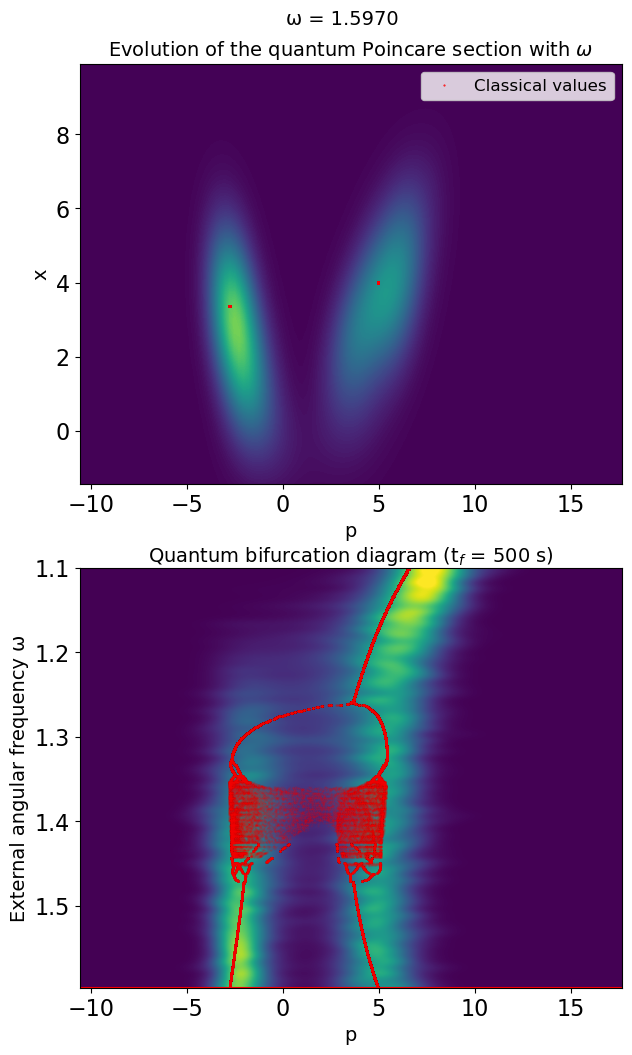

In [20]:
fig10 = plt.figure(figsize = (7,12), constrained_layout=True)

gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0.5)
nrm2 = mpl.colors.Normalize(0, 0.12)
ax10 = plt.subplot(gs[0, 0])
ax11 = plt.subplot(gs[1, 0])
ax10.contourf(wig_pvec*math.sqrt(w_0*m), wig_xvec/math.sqrt(w_0*m), np.transpose(qpoin[0]), 100, cmap=cm.viridis, norm=nrm)
im = ax11.imshow(np.flip(qbif,axis = 0),cmap='viridis',norm = nrm2, aspect = 'auto', extent = [min(wig_pvec*math.sqrt(w_0*m)),max(wig_pvec*math.sqrt(w_0*m)),min(w),max(w)])

for i in range(np.size(wc)):
    ax11.plot(np.array(vp[i][-300:],dtype=object),wc[i]*np.ones(300),'.',color='red',markersize='1',alpha=0.5)

ax11.plot([-20,20],[w[0],w[0]], color = 'red')

animP = animation.FuncAnimation(fig10, update_fig, np.size(w), fargs = (qbif,qpoin,xp,vp, ), interval = 250)
animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qev.gif', dpi=250)
#animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qev.mp4', dpi=250)

In [21]:
def update_fig(Num,qpoin,xp,vp):
    axe.cla()

    nrm = mpl.colors.Normalize(0, qpoin[Num].max())

    axe.contourf(wig_pvec*math.sqrt(w_0*m), wig_xvec/math.sqrt(w_0*m), np.transpose(qpoin[Num]), 100, cmap=cm.viridis, norm=nrm)
    
    axe.set_ylim(min(wig_xvec/math.sqrt(w_0*m)),max(wig_xvec/math.sqrt(w_0*m)))
    axe.set_xlim(min(wig_pvec*math.sqrt(w_0*m)),max(wig_pvec*math.sqrt(w_0*m)))
    axe.plot(vp[rep_w[Num]][50:]*m,xp[rep_w[Num]][50:],'.',color='red',markersize = 3, label = 'Classical values')
    axe.set_title('Evolution of the quantum Poincare section with $\omega$',fontsize = 14)
    axe.set_ylabel('x',fontsize = 14)
    axe.set_xlabel('p',fontsize = 14)

    fig11.suptitle('ω = '+str(format(w[Num],'.4f')), fontsize = 14)

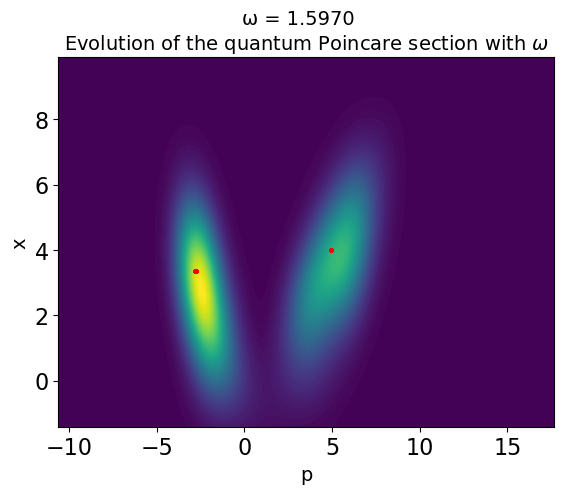

In [22]:
fig11,axe = plt.subplots()

nrm = mpl.colors.Normalize(0, qpoin[0].max())
axe.contourf(wig_pvec*math.sqrt(w_0*m), wig_xvec/math.sqrt(w_0*m), np.transpose(qpoin[0]), 100, cmap=cm.viridis, norm=nrm)

animP = animation.FuncAnimation(fig11, update_fig, np.size(w), fargs = (qpoin,xp,vp, ), interval = 100)
animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qev_P.gif', dpi=250)
animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qev.mp4', dpi=250)

In [26]:
xpT = []
vpT = []

tfT = 50000 # Tiempo de medida
tvecT = np.linspace(0,tfT,int(tfT/dt)+1) # Vector de instantes de tiempo
NpTT = int(tfT/TT) # Número de puntos que usamos en el promedio

solT = scipy.integrate.solve_ivp(EDO, [0,tfT], [X_0,0], method = 'RK23',t_eval = tvecT,args = [wT])
xT,vT = solT.y

In [27]:
for j in range(int(np.round(TT*10))):
    indT = np.array([np.searchsorted(tvecT,TT*(i+1)+j*0.1) for i in range(NpTT-1)]) # Calculamos los índices del diagrama de Poincaré
    xpT.append(xT[indT]) # Asignamos índices encontrados en tiempos con posiciones y velocidades (/max(x[ind]))
    vpT.append(vT[indT])

In [28]:
def update_fig1(Num,qpoinT,xp,vp):
    axg.cla()
    nrm = mpl.colors.Normalize(0, qpoinT[Num].max())
    axg.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), qpoinT[Num], 100, cmap=cm.viridis, norm=nrm)
    axg.set_xlim([np.min(wig_xvec/math.sqrt(w_0*m)),np.max(wig_xvec/math.sqrt(w_0*m))])
    axg.set_ylim([np.min(wig_pvec*math.sqrt(w_0*m)),np.max(wig_pvec*math.sqrt(w_0*m))])
    axg.plot(xpT[Num][50:],vpT[Num][50:]*m,'.',color='red',markersize = 1,label = 'Classical values')
    axg.set_xlabel('x',fontsize = 14)
    axg.set_ylabel('p',fontsize = 14)
    axg.set_title('Evolution of the quantum Poincare section (ω = '+str(format(wT,'.4f'))+')',fontsize = 14,y=1.15)
    fig16.suptitle('Stroboscopic times: nT+'+str(format(Num*0.1,'.1f'))+' s',fontsize = 14)

In [29]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

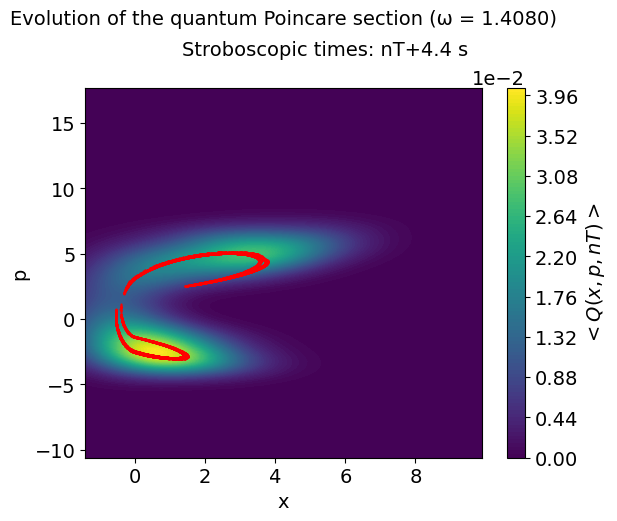

In [30]:
fig16,axg = plt.subplots()

nrm = mpl.colors.Normalize(0, qpoinT[0].max())
im = axg.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), qpoinT[0], 100, cmap=cm.viridis, norm=nrm)
axg.plot(xpT[0][50:],vpT[0][50:]*m,'.',color='red',markersize = 1,label = 'Classical values')
cbar4 = plt.colorbar(im,ax = axg, pad = 0.05)
cbar4.set_label(label='$<Q(x,p,nT)>$',fontsize = 14)
cbar4.formatter.set_powerlimits((0, 0))
animP = animation.FuncAnimation(fig16, update_fig1, int(np.round(TT*10)), fargs = (qpoinT,xp,vp, ), interval = 100)
animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qev_T.gif', dpi=250)
animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\mc_wvar/Qev_T.mp4', dpi=250)